In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
from torch import utils as t_utils
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device = torch.device("cpu")


In [20]:

train_data = pd.read_csv('./data/train.csv',dtype = np.float32)

train_data['label'] = train_data['label'].astype(int)
# test_data['label'] = test_data['label'].astype(int)

# convert to numpy
targets_numpy = train_data.label.values
features_numpy = train_data.loc[:,train_data.columns != "label"].values

# convert to tensor
targets_tensor = torch.from_numpy(targets_numpy).long()
features_tensor = torch.from_numpy(features_numpy).float()

# create dataset
dataset = TensorDataset(features_tensor, targets_tensor)
 
# split dataset
rows = train_data.shape[0]
test_size = int(rows*0.2)
train_size = rows - test_size
trainDataset, testDataset = random_split(dataset, [train_size, test_size])

# init loaders
batch_size = 64
trainLoader = DataLoader(trainDataset, batch_size=batch_size)
testLoader = DataLoader(testDataset, batch_size=batch_size)

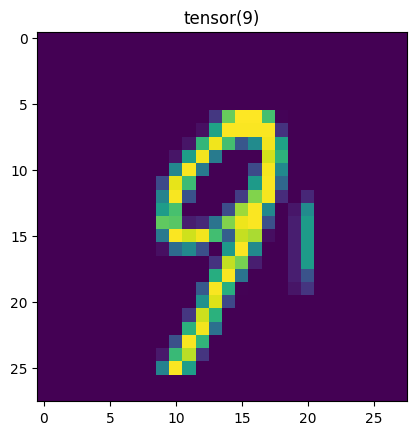

Label: 9


In [21]:
train_features, train_labels = next(iter(trainLoader))
img = torch.reshape(train_features[0], (28, 28)) 
label = train_labels[0]
plt.imshow(img)
plt.title(str(label))
plt.show()
print(f"Label: {label}")

In [22]:
class SimpleLinearNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        logits = self.linear(x)
        return logits
    
simpleLinearNeuralNetworkModel = SimpleLinearNeuralNetwork().to(device)
print(simpleLinearNeuralNetworkModel)

SimpleLinearNeuralNetwork(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [33]:
def train_loop(dataloader, model, criteria, optimizer):
    size = len(dataloader.dataset) 
    count = 0
    for batch, (X, y) in enumerate(dataloader): 
        pred = model(X)
        loss = criteria(pred, y)
        count += 1
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        if batch % 200 == 0: 
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print(count)


In [45]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct = 0
    test_loss = 0 
    with torch.no_grad():
        for (X, y) in dataloader: 
            pred = model(X) 
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() 
 
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [46]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(simpleLinearNeuralNetworkModel.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainLoader, simpleLinearNeuralNetworkModel, loss_fn, optimizer)
    test_loop(testLoader, simpleLinearNeuralNetworkModel, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 3.681502  [   64/33600]
loss: 3.253436  [12864/33600]
loss: 11.722382  [25664/33600]
525
Test Error: 
 Accuracy: 83.1%, Avg loss: 22.496655 

Epoch 2
-------------------------------
loss: 13.345912  [   64/33600]
loss: 2.727440  [12864/33600]
loss: 9.657930  [25664/33600]
525
Test Error: 
 Accuracy: 88.0%, Avg loss: 16.118379 

Epoch 3
-------------------------------
loss: 0.934724  [   64/33600]
loss: 5.987674  [12864/33600]
loss: 10.157700  [25664/33600]
525
Test Error: 
 Accuracy: 88.3%, Avg loss: 16.806620 

Epoch 4
-------------------------------
loss: 4.865849  [   64/33600]
loss: 5.065780  [12864/33600]
loss: 9.020833  [25664/33600]
525
Test Error: 
 Accuracy: 86.2%, Avg loss: 18.759594 

Epoch 5
-------------------------------
loss: 4.511963  [   64/33600]
loss: 4.775049  [12864/33600]
loss: 11.979399  [25664/33600]
525
Test Error: 
 Accuracy: 88.2%, Avg loss: 15.522391 

Done!


In [47]:
test_loop(testLoader, simpleLinearNeuralNetworkModel, loss_fn)




Test Error: 
 Accuracy: 88.2%, Avg loss: 15.522391 



In [27]:

loaderIterator = iter(testLoader) 

In [28]:

def predict_and_show(model, loaderIterator):
    train_features, train_labels = next(loaderIterator)
    with torch.no_grad():
        img = torch.reshape(train_features[0], (28, 28))  
        pred = model(train_features)
        label = torch.argmax(pred[0])  
        plt.imshow(img)
        plt.title(f"predicted: {str(label)}, actual: {str(train_labels[0])}")
        plt.show() 




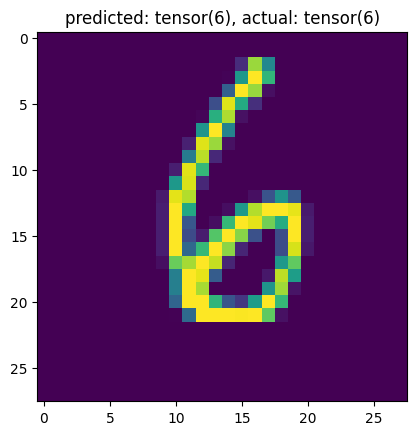

In [29]:
predict_and_show(simpleLinearNeuralNetworkModel, loaderIterator) 
 

In [30]:
class SimpleLinearNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Conv2d(kernel_size=3, stride=1, padding=0, in_channels=1, out_channels=16),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            
            # nn.Linear(32*4*4, 10),

            nn.Linear(28*28, 512),
            nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            # nn.Linear(512, 10)
        )

        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        # print('forward1')
        # print(x.size())
        # self.linear.weight = self.linear.weight.long()
        # print(self.linear.weight.dtype)
        # print(self.linear.bias.dtype)
        # print(x.dtype)
        # x = self.flatten(x)
        # print('forward2')
        logits = self.linear(x)
        
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NameError: name 'NeuralNetwork' is not defined